# Introduction

## Objectif du Notebook
L'objectif de ce notebook est de développer et d'évaluer des modèles avancés d'analyse de sentiments en utilisant des architectures de réseaux de neurones convolutionnels (CNN) et de réseaux de neurones récurrents (LSTM). Ces modèles seront entraînés sur un jeu de données de tweets et utiliseront des embeddings textuels pré-entraînés tels que Word2Vec et FastText pour capturer les relations sémantiques entre les mots.

## Présentation des Méthodes CNN et LSTM
Le Convolutional Neural Network (CNN) et le Long Short-Term Memory (LSTM) sont deux types d'architectures de réseaux de neurones particulièrement adaptées au traitement des données séquentielles telles que le texte.

### CNN (Convolutional Neural Network)
Les CNN sont bien connus pour leur capacité à détecter des motifs locaux dans les données séquentielles, ce qui les rend efficaces pour capturer des n-grams de mots dans les textes. Dans ce notebook, nous utiliserons un CNN pour analyser les séquences de mots des tweets et en extraire des caractéristiques pertinentes pour la classification de sentiments.

### LSTM (Long Short-Term Memory)
Les LSTM sont un type de réseau de neurones récurrents (RNN) capable de capturer des dépendances à long terme dans des séquences de données. Cela les rend particulièrement efficaces pour comprendre le contexte complet d'une phrase ou d'un tweet, en tenant compte de l'ordre des mots et des relations temporelles.

## Plan du Notebook
Ce notebook est structuré de manière à suivre un pipeline complet de traitement des données, d'entraînement des modèles et d'évaluation des performances :
1. **Chargement et Préparation des Données** : Nous allons commencer par charger les données, les nettoyer, les tokeniser et les préparer pour les modèles CNN et LSTM.
2. **Préparation des Embeddings Textuels** : Nous utiliserons Word2Vec et FastText pour convertir les séquences de mots en vecteurs denses.
3. **Construction du Modèle CNN** : Nous définirons et entraînerons un modèle CNN pour la tâche de classification de sentiments.
4. **Construction du Modèle LSTM** : Nous définirons et entraînerons un modèle LSTM pour la même tâche.
5. **Évaluation des Modèles** : Nous comparerons les performances des deux modèles pour déterminer lequel est le plus performant.
6. **Exportation et Sauvegarde des Modèles** : Nous sauvegarderons le meilleur modèle pour une utilisation future.
7. **Conclusion** : Nous résumerons les résultats et discuterons des perspectives d'amélioration.


# 1. Chargement et Préparation des Données

## 1.1 Importation des bibliothèques nécessaires


In [4]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## 1.2 Chargement des données et transformation de la cible target


In [6]:
# Charger les données
data = pd.read_csv('../data/database_p7_rework.csv')

# Transformation des labels : 0 reste 0 et 4 devient 1
data['target_binary'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

# Vérification des transformations
print("Unique values in target_binary:", data['target_binary'].unique())



Unique values in target_binary: [0 1]


## 1.3 Tokenisation

In [8]:
# Fonction pour préparer les séquences
def prepare_sequences(texts, tokenizer, maxlen=25):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=maxlen)

# Tokenization
tokenizer_lemma = Tokenizer(num_words=5000)
tokenizer_lemma.fit_on_texts(data['text_lemmatized'])

tokenizer_stem = Tokenizer(num_words=5000)
tokenizer_stem.fit_on_texts(data['text_stemmed'])

# Préparation des séquences
X_lemma = prepare_sequences(data['text_lemmatized'], tokenizer_lemma)
X_stem = prepare_sequences(data['text_stemmed'], tokenizer_stem)

# Séparation des données
y = data['target_binary']

X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma, y, test_size=0.2, random_state=42)
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y, test_size=0.2, random_state=42)

# 2 Préparation des Embeddings Textuels

In [10]:
# Charger les modèles Word2Vec et FastText pré-entraînés (300 dimensions)
w2v_model = api.load('word2vec-google-news-300')
ft_model = api.load('fasttext-wiki-news-subwords-300')

# Fonction pour créer la matrice d'embeddings
def create_embedding_matrix(tokenizer, embedding_model, embedding_dim=300):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]
    return embedding_matrix

# Créer les matrices d'embeddings
embedding_matrix_lemma_w2v = create_embedding_matrix(tokenizer_lemma, w2v_model)
embedding_matrix_stem_w2v = create_embedding_matrix(tokenizer_stem, w2v_model)

embedding_matrix_lemma_ft = create_embedding_matrix(tokenizer_lemma, ft_model)
embedding_matrix_stem_ft = create_embedding_matrix(tokenizer_stem, ft_model)


# 3. Définition de l'architecture du modèle CNN

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Fonction pour créer un modèle CNN
def create_cnn_model(input_dim, embedding_matrix, max_length=100):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model




# 4. Définition de l'architecture du modèle LSTM

In [14]:
from keras.layers import LSTM, Bidirectional

# Fonction pour créer un modèle LSTM
def create_lstm_model(input_dim, embedding_matrix, max_length=100):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



# 5. Entraînement et Évaluation des Modèles

## 5.1 Entraînement des Modèles CNN et LSTM avec les Embeddings Word2Vec + lemmatisation

2024/09/02 12:09:49 INFO mlflow.tracking.fluent: Experiment with name 'cnn_model_lemma_w2v' does not exist. Creating a new experiment.
D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.7757 - loss: 0.4691 - val_accuracy: 0.8010 - val_loss: 0.4271
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.8092 - loss: 0.4151 - val_accuracy: 0.8056 - val_loss: 0.4191
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.8191 - loss: 0.3963 - val_accuracy: 0.8077 - val_loss: 0.4154
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.8266 - loss: 0.3827 - val_accuracy: 0.8086 - val_loss: 0.4168
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.8327 - loss: 0.3706 - val_accuracy: 0.8063 - val_loss: 0.4297
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.8376 - loss: 0.3608 - val_accuracy: 0.8087 - val_loss: 0.4224
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.8424 - loss: 0.3518 - val_accuracy: 0.8068 - val_loss: 0.4334
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 

2024/09/02 12:18:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 12:18:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


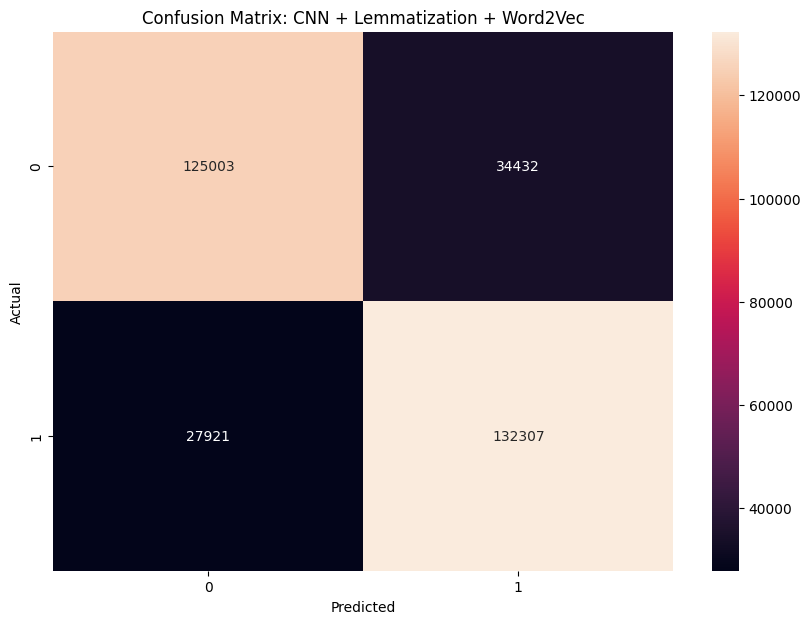

In [77]:
import mlflow
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Définir le dossier racine où vous voulez enregistrer les artefacts MLflow
base_dir = os.path.abspath(os.path.join("..", "mlruns"))

# Exemple pour CNN avec lemmatisation + Word2Vec
model_name = "cnn_model_lemma_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    cnn_model_lemma_w2v = create_cnn_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_w2v)
    cnn_model_lemma_w2v.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(cnn_model_lemma_w2v, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_lemma_w2v = (cnn_model_lemma_w2v.predict(X_test_lemma) > 0.5).astype("int32")
    accuracy_lemma_w2v = accuracy_score(y_test_lemma, y_pred_lemma_w2v)
    mlflow.log_metric("accuracy_lemma_w2v", accuracy_lemma_w2v)

    # Créer et afficher la matrice de confusion
    cm_lemma_w2v = confusion_matrix(y_test_lemma, y_pred_lemma_w2v)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_lemma_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Lemmatization + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


2024/09/02 12:19:01 INFO mlflow.tracking.fluent: Experiment with name 'lstm_model_lemma_w2v' does not exist. Creating a new experiment.
D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 262s 16ms/step - accuracy: 0.7629 - loss: 0.4869 - val_accuracy: 0.8089 - val_loss: 0.4144
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 253s 16ms/step - accuracy: 0.8081 - loss: 0.4169 - val_accuracy: 0.8175 - val_loss: 0.4001
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 252s 16ms/step - accuracy: 0.8182 - loss: 0.3990 - val_accuracy: 0.8213 - val_loss: 0.3932
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 268s 17ms/step - accuracy: 0.8244 - loss: 0.3881 - val_accuracy: 0.8249 - val_loss: 0.3871
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 263s 16ms/step - accuracy: 0.8289 - loss: 0.3798 - val_accuracy: 0.8266 - val_loss: 0.3856
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 270s 17ms/step - accuracy: 0.8314 - loss: 0.3741 - val_accuracy: 0.8269 - val_loss: 0.3837
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 319s 20ms/step - accuracy: 0.8338 - loss: 0.3698 - val_accuracy: 0.8279 - val_loss: 0.3829
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 337s 21ms/s

2024/09/02 13:08:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 13:08:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step


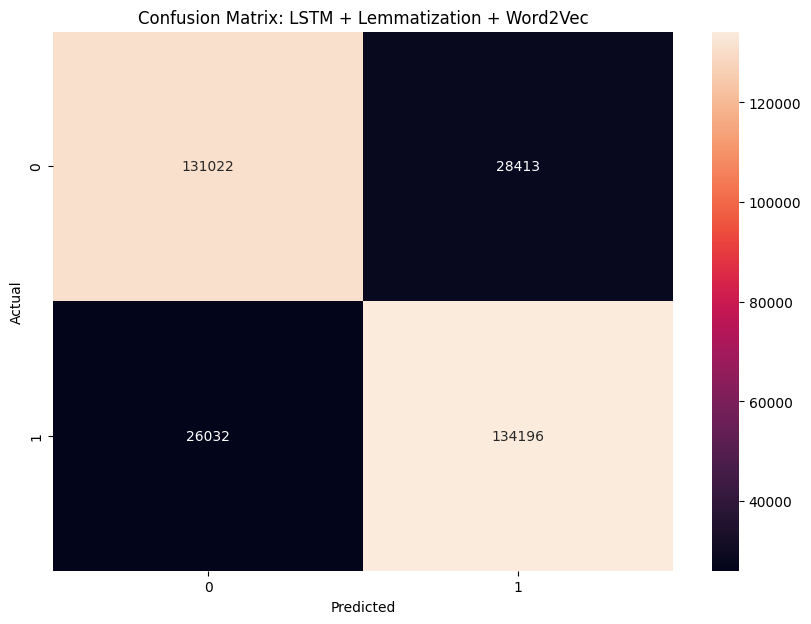

In [78]:
# Modèle LSTM avec Lemmatization + Word2Vec
model_name = "lstm_model_lemma_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    lstm_model_lemma_w2v = create_lstm_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_w2v)
    lstm_model_lemma_w2v.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(lstm_model_lemma_w2v, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_lemma_w2v = (lstm_model_lemma_w2v.predict(X_test_lemma) > 0.5).astype("int32")
    accuracy_lemma_w2v = accuracy_score(y_test_lemma, y_pred_lemma_w2v)
    mlflow.log_metric("accuracy_lemma_w2v", accuracy_lemma_w2v)

    # Créer et afficher la matrice de confusion
    cm_lemma_w2v = confusion_matrix(y_test_lemma, y_pred_lemma_w2v)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_lemma_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Lemmatization + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 5.2 Entraînement des Modèles CNN et LSTM avec les Embeddings FastText + lemmatisation

2024/09/02 13:09:18 INFO mlflow.tracking.fluent: Experiment with name 'cnn_model_lemma_ft' does not exist. Creating a new experiment.
D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.7685 - loss: 0.4783 - val_accuracy: 0.8008 - val_loss: 0.4296
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.8056 - loss: 0.4207 - val_accuracy: 0.8055 - val_loss: 0.4212
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.8146 - loss: 0.4050 - val_accuracy: 0.8067 - val_loss: 0.4214
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.8196 - loss: 0.3955 - val_accuracy: 0.8091 - val_loss: 0.4154
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.8246 - loss: 0.3854 - val_accuracy: 0.8111 - val_loss: 0.4120
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.8280 - loss: 0.3797 - val_accuracy: 0.8116 - val_loss: 0.4115
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.8318 - loss: 0.3725 - val_accuracy: 0.8105 - val_loss: 0.4178
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 

2024/09/02 13:21:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 13:21:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


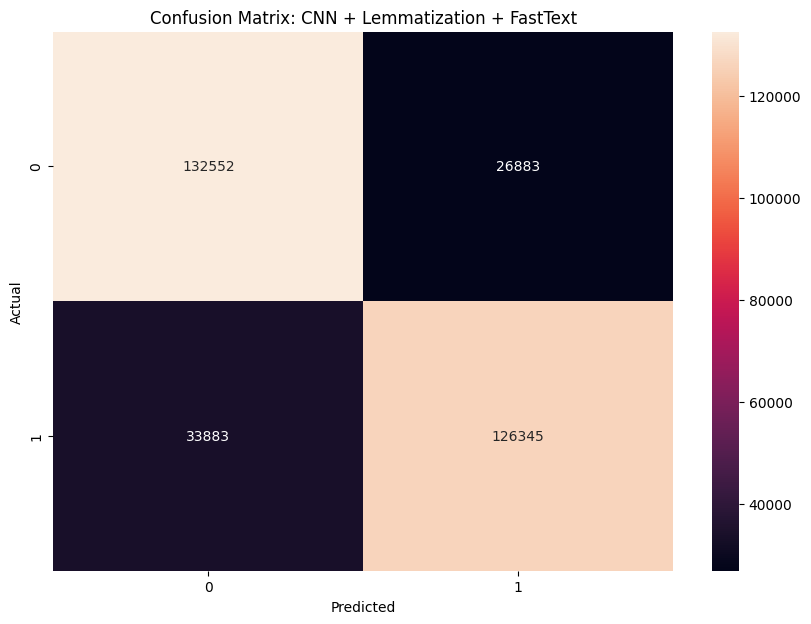

In [79]:
# Modèle CNN avec Lemmatization + FastText
model_name = "cnn_model_lemma_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    cnn_model_lemma_ft = create_cnn_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_ft)
    cnn_model_lemma_ft.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(cnn_model_lemma_ft, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_lemma_ft = (cnn_model_lemma_ft.predict(X_test_lemma) > 0.5).astype("int32")
    accuracy_lemma_ft = accuracy_score(y_test_lemma, y_pred_lemma_ft)
    mlflow.log_metric("accuracy_lemma_ft", accuracy_lemma_ft)

    # Créer et afficher la matrice de confusion
    cm_lemma_ft = confusion_matrix(y_test_lemma, y_pred_lemma_ft)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_lemma_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Lemmatization + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


2024/09/02 13:22:11 INFO mlflow.tracking.fluent: Experiment with name 'lstm_model_lemma_ft' does not exist. Creating a new experiment.
D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 279s 17ms/step - accuracy: 0.7554 - loss: 0.4994 - val_accuracy: 0.8034 - val_loss: 0.4251
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 271s 17ms/step - accuracy: 0.8021 - loss: 0.4283 - val_accuracy: 0.8126 - val_loss: 0.4094
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 272s 17ms/step - accuracy: 0.8108 - loss: 0.4122 - val_accuracy: 0.8184 - val_loss: 0.3986
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 278s 17ms/step - accuracy: 0.8176 - loss: 0.4004 - val_accuracy: 0.8215 - val_loss: 0.3926
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 280s 18ms/step - accuracy: 0.8224 - loss: 0.3909 - val_accuracy: 0.8239 - val_loss: 0.3877
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 284s 18ms/step - accuracy: 0.8261 - loss: 0.3840 - val_accuracy: 0.8259 - val_loss: 0.3848
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 298s 19ms/step - accuracy: 0.8285 - loss: 0.3804 - val_accuracy: 0.8269 - val_loss: 0.3841
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 306s 19ms/s

2024/09/02 14:10:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 14:11:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 65s 7ms/step


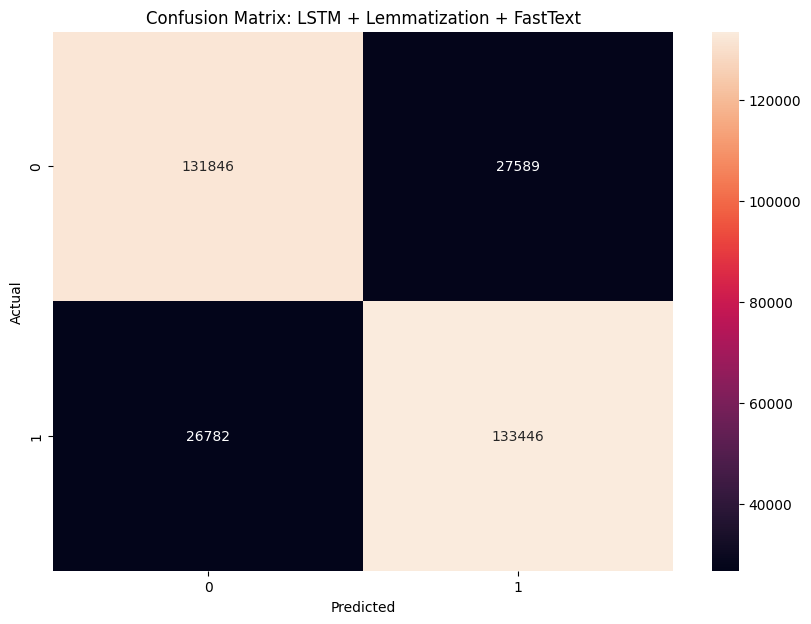

In [80]:
# Modèle LSTM avec Lemmatization + FastText
model_name = "lstm_model_lemma_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    lstm_model_lemma_ft = create_lstm_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_ft)
    lstm_model_lemma_ft.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(lstm_model_lemma_ft, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_lemma_ft = (lstm_model_lemma_ft.predict(X_test_lemma) > 0.5).astype("int32")
    accuracy_lemma_ft = accuracy_score(y_test_lemma, y_pred_lemma_ft)
    mlflow.log_metric("accuracy_lemma_ft", accuracy_lemma_ft)

    # Créer et afficher la matrice de confusion
    cm_lemma_ft = confusion_matrix(y_test_lemma, y_pred_lemma_ft)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_lemma_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Lemmatization + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 5.3 Entraînement des Modèles CNN et LSTM avec les Embeddings Word2Vec + stemming

2024/09/02 14:12:10 INFO mlflow.tracking.fluent: Experiment with name 'cnn_model_stem_w2v' does not exist. Creating a new experiment.
D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.7608 - loss: 0.4911 - val_accuracy: 0.7881 - val_loss: 0.4478
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.7976 - loss: 0.4345 - val_accuracy: 0.7945 - val_loss: 0.4384
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.8076 - loss: 0.4168 - val_accuracy: 0.7967 - val_loss: 0.4352
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.8153 - loss: 0.4032 - val_accuracy: 0.7967 - val_loss: 0.4348
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.8209 - loss: 0.3917 - val_accuracy: 0.7968 - val_loss: 0.4437
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.8261 - loss: 0.3820 - val_accuracy: 0.7975 - val_loss: 0.4370
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.8310 - loss: 0.3717 - val_accuracy: 0.7956 - val_loss: 0.4446
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 

2024/09/02 14:24:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 14:24:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


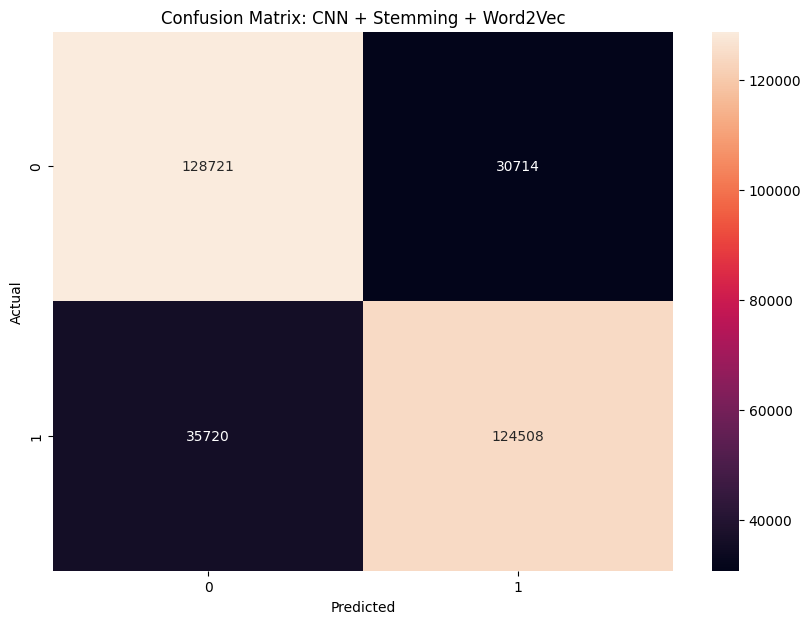

In [81]:
# Modèle CNN avec Stemming + Word2Vec
model_name = "cnn_model_stem_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    cnn_model_stem_w2v = create_cnn_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_w2v)
    cnn_model_stem_w2v.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(cnn_model_stem_w2v, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_stem_w2v = (cnn_model_stem_w2v.predict(X_test_stem) > 0.5).astype("int32")
    accuracy_stem_w2v = accuracy_score(y_test_stem, y_pred_stem_w2v)
    mlflow.log_metric("accuracy_stem_w2v", accuracy_stem_w2v)

    # Créer et afficher la matrice de confusion
    cm_stem_w2v = confusion_matrix(y_test_stem, y_pred_stem_w2v)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_stem_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Stemming + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
# Modèle LSTM avec Stemming + Word2Vec
model_name = "lstm_model_stem_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    lstm_model_stem_w2v = create_lstm_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_w2v)
    lstm_model_stem_w2v.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(lstm_model_stem_w2v, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_stem_w2v = (lstm_model_stem_w2v.predict(X_test_stem) > 0.5).astype("int32")
    accuracy_stem_w2v = accuracy_score(y_test_stem, y_pred_stem_w2v)
    mlflow.log_metric("accuracy_stem_w2v", accuracy_stem_w2v)

    # Créer et afficher la matrice de confusion
    cm_stem_w2v = confusion_matrix(y_test_stem, y_pred_stem_w2v)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_stem_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Stemming + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


2024/09/02 14:24:46 INFO mlflow.tracking.fluent: Experiment with name 'lstm_model_stem_w2v' does not exist. Creating a new experiment.
D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 285s 17ms/step - accuracy: 0.7483 - loss: 0.5085 - val_accuracy: 0.7964 - val_loss: 0.4355
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 281s 18ms/step - accuracy: 0.7953 - loss: 0.4388 - val_accuracy: 0.8041 - val_loss: 0.4209
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 291s 18ms/step - accuracy: 0.8049 - loss: 0.4214 - val_accuracy: 0.8102 - val_loss: 0.4147
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 297s 19ms/step - accuracy: 0.8116 - loss: 0.4106 - val_accuracy: 0.8131 - val_loss: 0.4085
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 334s 21ms/step - accuracy: 0.8164 - loss: 0.4012 - val_accuracy: 0.8148 - val_loss: 0.4053
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 306s 19ms/step - accuracy: 0.8195 - loss: 0.3951 - val_accuracy: 0.8162 - val_loss: 0.4078
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 330s 21ms/step - accuracy: 0.8213 - loss: 0.3914 - val_accuracy: 0.8145 - val_loss: 0.4067
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 355s 22ms/s

## 5.4 Entraînement des Modèles CNN et LSTM avec les Embeddings FastText + stemming

In [ ]:
# Modèle CNN avec Stemming + FastText
model_name = "cnn_model_stem_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    cnn_model_stem_ft = create_cnn_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_ft)
    cnn_model_stem_ft.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(cnn_model_stem_ft, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_stem_ft = (cnn_model_stem_ft.predict(X_test_stem) > 0.5).astype("int32")
    accuracy_stem_ft = accuracy_score(y_test_stem, y_pred_stem_ft)
    mlflow.log_metric("accuracy_stem_ft", accuracy_stem_ft)

    # Créer et afficher la matrice de confusion
    cm_stem_ft = confusion_matrix(y_test_stem, y_pred_stem_ft)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_stem_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Stemming + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
# Modèle LSTM avec Stemming + FastText
model_name = "lstm_model_stem_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    lstm_model_stem_ft = create_lstm_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_ft)
    lstm_model_stem_ft.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(lstm_model_stem_ft, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_stem_ft = (lstm_model_stem_ft.predict(X_test_stem) > 0.5).astype("int32")
    accuracy_stem_ft = accuracy_score(y_test_stem, y_pred_stem_ft)
    mlflow.log_metric("accuracy_stem_ft", accuracy_stem_ft)

    # Créer et afficher la matrice de confusion
    cm_stem_ft = confusion_matrix(y_test_stem, y_pred_stem_ft)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_stem_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Stemming + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# 6. Comparaison des modèles

In [ ]:
import pandas as pd

# Initialiser une liste pour stocker les résultats
results = []

# Fonction pour ajouter les résultats d'un modèle à la liste
def log_results(model_name, accuracy, precision, recall, f1):
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Log des résultats pour les modèles avancés (Word2Vec + FastText)

# CNN + Lemmatization + Word2Vec
log_results(
    'CNN + Lemmatization + Word2Vec',
    accuracy_cnn_lemma_w2v,
    precision_cnn_lemma_w2v,
    recall_cnn_lemma_w2v,
    f1_cnn_lemma_w2v
)

# LSTM + Lemmatization + Word2Vec
log_results(
    'LSTM + Lemmatization + Word2Vec',
    accuracy_lstm_lemma_w2v,
    precision_lstm_lemma_w2v,
    recall_lstm_lemma_w2v,
    f1_lstm_lemma_w2v
)

# CNN + Stemming + Word2Vec
log_results(
    'CNN + Stemming + Word2Vec',
    accuracy_cnn_stem_w2v,
    precision_cnn_stem_w2v,
    recall_cnn_stem_w2v,
    f1_cnn_stem_w2v
)

# LSTM + Stemming + Word2Vec
log_results(
    'LSTM + Stemming + Word2Vec',
    accuracy_lstm_stem_w2v,
    precision_lstm_stem_w2v,
    recall_lstm_stem_w2v,
    f1_lstm_stem_w2v
)

# CNN + Lemmatization + FastText
log_results(
    'CNN + Lemmatization + FastText',
    accuracy_cnn_lemma_ft,
    precision_cnn_lemma_ft,
    recall_cnn_lemma_ft,
    f1_cnn_lemma_ft
)

# LSTM + Lemmatization + FastText
log_results(
    'LSTM + Lemmatization + FastText',
    accuracy_lstm_lemma_ft,
    precision_lstm_lemma_ft,
    recall_lstm_lemma_ft,
    f1_lstm_lemma_ft
)

# CNN + Stemming + FastText
log_results(
    'CNN + Stemming + FastText',
    accuracy_cnn_stem_ft,
    precision_cnn_stem_ft,
    recall_cnn_stem_ft,
    f1_cnn_stem_ft
)

# LSTM + Stemming + FastText
log_results(
    'LSTM + Stemming + FastText',
    accuracy_lstm_stem_ft,
    precision_lstm_stem_ft,
    recall_lstm_stem_ft,
    f1_lstm_stem_ft
)

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Afficher le tableau récapitulatif
print(results_df)

